In [38]:
import heartpy as hp
import math
import matplotlib.pyplot as plt
import numpy as np
import os.path
import pandas as pd
import seaborn as sns
import xgboost as xgb
import pickle

from os import path
from scipy.stats import mode
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from xgboost import plot_importance, plot_tree

## Extra for last example
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from matplotlib import pyplot

plt.style.use('fivethirtyeight') ## might not need this, from the xgboost plotting tutorial

## Set the participant we're analyzing

PARTICIPANT = "participant_29"

## How training and testing sets are handled, options: A, B, C, D
TRAIN_TEST_SET_TYPE = 'D'
TEST_SIZES = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9] ## here the test size is dynamic and training size changes proportionally
TRAIN_SIZES = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8] #[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]## here the test size is fixed as 20% of the data
print("Necessary packages imported.")



Necessary packages imported.


In [39]:
###########################
## Load or Compile Files ##
###########################

if path.exists("data/saved/" + PARTICIPANT):
    ## Read in already saved dataframe
    print("file data already extracted, opening...")
    data = pd.read_pickle("data/saved/" + PARTICIPANT)
    print("successfully opened")
    pass

else:
    print("compiling individual data files...")

    ## Collect each mini .csv file to a df
    individual_dfs = []
    for f in os.listdir("data/raw/" + PARTICIPANT):
        small_df = pd.read_csv("data/raw/"+ PARTICIPANT + "/" + f, header=0)
        individual_dfs.append(small_df)

    ## Put these dfs together
    data = pd.concat(individual_dfs, axis=0)

    ## Format the time correctly
    data["time"] = data['year'].astype(str) + "-" + data['month'].astype(str) + "-" + data['day'].astype(str) + " " + data['hour'].astype(str) + "-" + data['minute'].astype(str) + "-" + data['second'].astype(str)
    data = data.drop(["id", "year", "month", "day", "hour", "minute", "second"], axis=1)
    data = data.set_index("time")

    ## Sort by time
    data = data.sort_index()

    ## Filter IR to BVP with a highpass filter
    data['ir'] = hp.filter_signal(data["ir"], cutoff = 0.75, sample_rate = 100.0)
    data.rename(columns = {'ir':'bvp'}, inplace = True)

    ## Smooth pump and vacuum labels
    data['pump_on'] = data['pump_on'].rolling(10, center=True).apply(lambda x: mode(x)[0])
    data['vacuum_on'] = data['vacuum_on'].rolling(10, center=True).apply(lambda x: mode(x)[0])

    ## Drop first 5% and last 5% as outliers
    front_drop = int(0.05*(len(data)))
    end_drop = len(data) - front_drop
    data = data[front_drop:end_drop]

    ## Save to .pkl file
    data.to_pickle("data/saved/" + PARTICIPANT)
    print("combined files saved")

print("\n *** DATA PREVIEW ***")
print(data.head())


file data already extracted, opening...
successfully opened

 *** DATA PREVIEW ***
                             bvp   bpm  pump_on  vacuum_on   temp     x     y  \
time                                                                            
2022-3-4 12-12-26  181207.416748  0.35      0.0        0.0  27.65 -8.98 -2.56   
2022-3-4 12-12-26  181313.666647  0.35      0.0        0.0  27.75 -8.95 -2.58   
2022-3-4 12-12-26  181421.332135  0.35      0.0        0.0  27.75 -9.12 -2.54   
2022-3-4 12-12-27  181530.091060  0.35      0.0        0.0  27.54 -8.98 -2.60   
2022-3-4 12-12-27  181639.638032  0.35      0.0        0.0  27.65 -8.96 -2.62   

                      z  
time                     
2022-3-4 12-12-26 -1.43  
2022-3-4 12-12-26 -1.06  
2022-3-4 12-12-26 -1.52  
2022-3-4 12-12-27 -1.04  
2022-3-4 12-12-27 -1.22  


In [8]:
###########################################
## Function(s) for Getting Dataset Stats ##
###########################################

def count_events(df):
    """
    Counts the number of pump on and pump off events for a given participant
    :param df: dataframe containing both a 'pump on' column and a 'vacuum on' column
    :return: int: num_pump_events, int: num_vacuum_events
    """

    ## Variable set up
    num_pump_events = 0
    ctr_pump =  0
    previous_pump = 'off'
    num_vacuum_events = 0
    ctr_vacuum = 0
    previous_vacuum = 'off'

    ## Extract df values so that it's easier to iterate over them
    values_pump = df['pump_on'].tolist()
    values_vacuum = df['vacuum_on'].tolist()

    ## Iterate over all of the pump values
    for i in range(1, len(values_pump)):

        ## Check to see if there is a change from 'off' to 'on, if so, add to the number of events
        if previous_pump != values_pump[i] and values_pump[i] == "on":
            previous_pump = values_pump[i]
            num_pump_events += 1
            ctr_pump += 1

        ## Don't add to the number of events if you are going from 'on' to 'off', avoids double counting
        elif previous_pump != values_pump[i] and values_pump[i] == "off":
            previous_pump = values_pump[i]
            ctr_pump +=1

        ## No change, just increase counter
        else:
            ctr_pump +=1

    for i in range(1, len(values_vacuum)):

        ## Check to see if there is a change from 'off' to 'on, if so, add to the number of events
        if previous_vacuum != values_vacuum[i] and values_vacuum[i] == "on":
            previous_vacuum = values_vacuum[i]
            num_vacuum_events += 1
            ctr_vacuum += 1

        ## Don't add to the number of events if you are going from 'on' to 'off', avoids double counting
        elif previous_vacuum != values_vacuum[i] and values_vacuum[i] == "off":
            previous_vacuum = values_vacuum[i]
            ctr_vacuum +=1

        ## No change, just increase the counter
        else:
            ctr_vacuum +=1

    ## figure out how to return time stamps for each of these events?
    ## find longest and shortest activation
    ## find average length of activation

    return num_pump_events, num_vacuum_events

In [40]:
############################
## Descriptive Statistics ##
############################

file_name = "reports/" + PARTICIPANT + "_stats_report.txt"

## Check to see if a report has already been generated
if path.exists(file_name):
    print("Report for {} already exists at {}".format(PARTICIPANT, file_name))

## If it hasn't been generated, create one
else:
    print("Generating report for {}...".format(PARTICIPANT))

    ## Divide into continuous and categorical
    continuous_cols = data[["bvp", "bpm", "temp", "x", "y", "z"]]
    categorical_cols = data[["pump_on", "vacuum_on"]]
    categorical_cols = categorical_cols.replace({0.0: "off", 1.0: "on"})

    ## Continuous column stat
    num_nan_cont = continuous_cols.isna().sum()
    descriptive_stats_cont = continuous_cols.describe()
    kurt = continuous_cols.kurtosis()
    skew = continuous_cols.skew()

    ## Categorical column stats - automatic
    num_nan_cat = categorical_cols.isna().sum()
    descriptive_stats_cat = categorical_cols.describe()
    pump_counts  = categorical_cols["pump_on"].value_counts()
    vacuum_counts = categorical_cols["vacuum_on"].value_counts()

    ## Categorical column stats - manual
    percentage_pump_off = pump_counts[0] / len(categorical_cols) * 100
    percentage_pump_on = 100 - percentage_pump_off
    percentage_vacuum_off = vacuum_counts[0] / len(categorical_cols) * 100
    percentage_vacuum_on = 100 - percentage_vacuum_off
    num_pump_on, num_vacuum_on = count_events(categorical_cols)
    # maybe extract lengths of pump time on and off?? do later if you have time

    ## Write all of these metrics to a .txt report file to look at later
    with open(file_name, 'w') as f:
        f.write("Number Nan - Continuous Columns\n")
        f.write(num_nan_cont.to_string(header=True, index=True) + '\n')

        f.write("Descriptive Stats - Continuous Columns\n")
        f.write(descriptive_stats_cont.to_string(header=True, index=True) + "\n")

        f.write("Kurtosis - Continous Columns\n")
        f.write(kurt.to_string(header=True, index=True) + "\n")

        f.write("Skew - Continous Columns\n")
        f.write(skew.to_string(header=True, index=True) + "\n")

        f.write("Number Nan - Categorical Columns\n")
        f.write(num_nan_cat.to_string(header=True, index=True) + "\n")

        f.write("Descriptive Stats - Categorical Columns\n")
        f.write(descriptive_stats_cat.to_string(header=True, index=True) + "\n")

        f.write("Pump Value Counts\n")
        f.write(pump_counts.to_string(header=True, index=True) + "\n")

        f.write("Vacuum Value Counts\n")
        f.write(vacuum_counts.to_string(header=True, index=True) + "\n")

        f.write("Percentage of Time Pump On:\n")
        f.write(str(percentage_pump_on) + "\n")

        f.write("Percentage of Time Pump Off:\n")
        f.write(str(percentage_pump_off) + "\n")

        f.write("Percentage of Time Vacuum On:\n")
        f.write(str(percentage_vacuum_on) + "\n")

        f.write("Percentage of Time Vacuum Off:\n")
        f.write(str(percentage_vacuum_off) + "\n")

        f.write("Number of Pump On Events:\n")
        f.write(str(num_pump_on) + "\n")

        f.write("Number of Vacuum on Events\n")
        f.write(str(num_vacuum_on) + "\n")

    print("Report successfully generated for {} and saved to {}".format(PARTICIPANT, file_name))

Generating report for participant_29...
Report successfully generated for participant_29 and saved to reports/participant_29_stats_report.txt


/tmp/ipykernel_5207/3135219044.py:53: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure_2 = plt.figure()


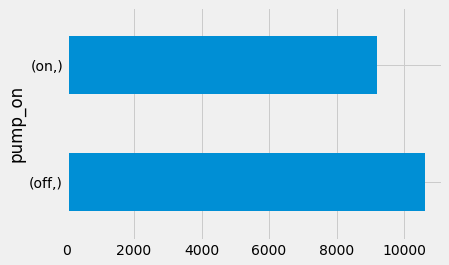

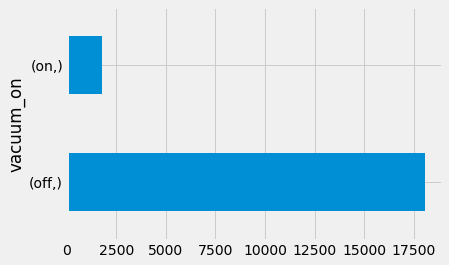

<Figure size 432x288 with 0 Axes>

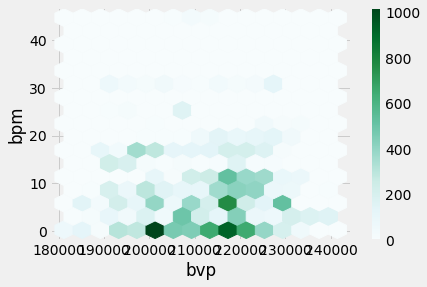

<Figure size 432x288 with 0 Axes>

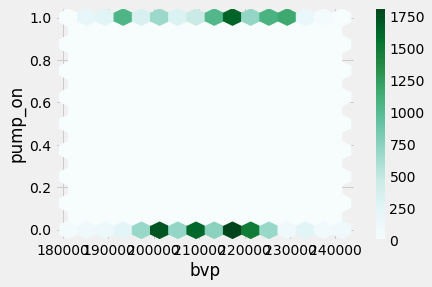

<Figure size 432x288 with 0 Axes>

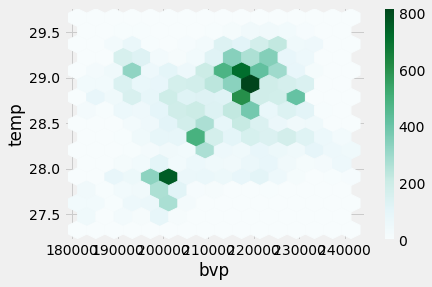

<Figure size 432x288 with 0 Axes>

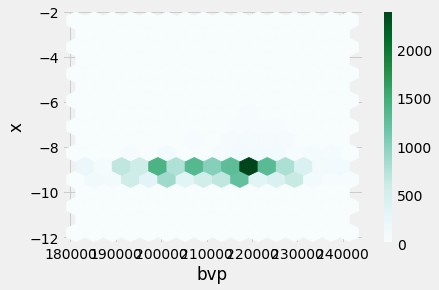

<Figure size 432x288 with 0 Axes>

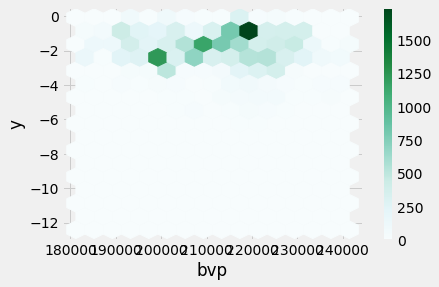

<Figure size 432x288 with 0 Axes>

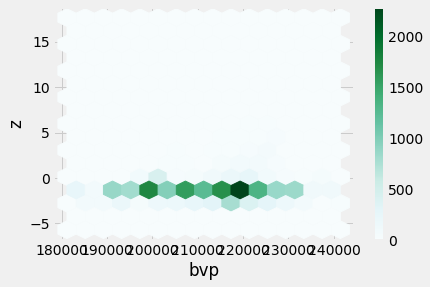

<Figure size 432x288 with 0 Axes>

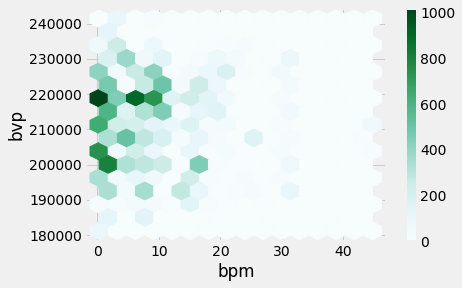

<Figure size 432x288 with 0 Axes>

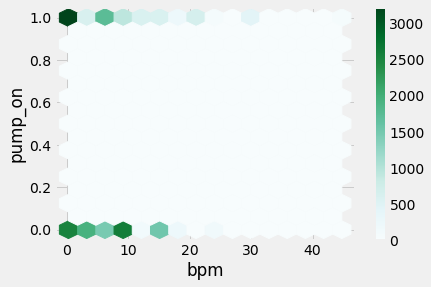

<Figure size 432x288 with 0 Axes>

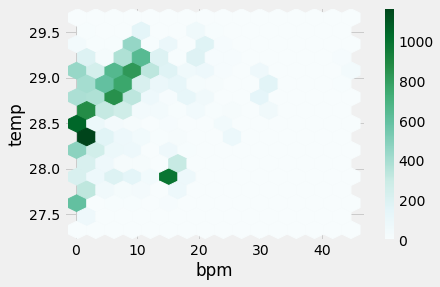

<Figure size 432x288 with 0 Axes>

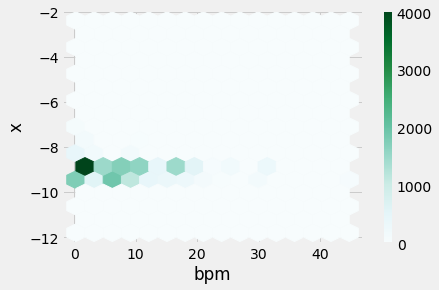

<Figure size 432x288 with 0 Axes>

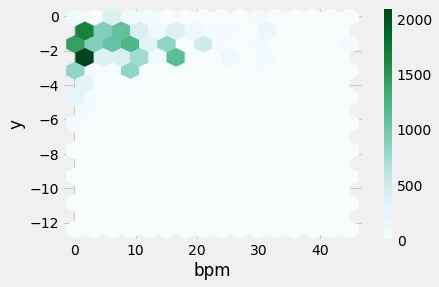

<Figure size 432x288 with 0 Axes>

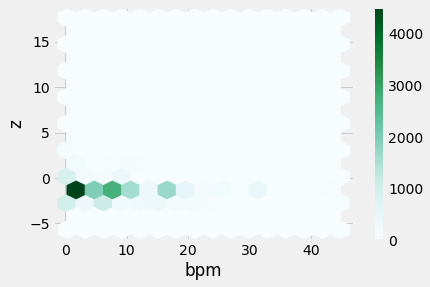

<Figure size 432x288 with 0 Axes>

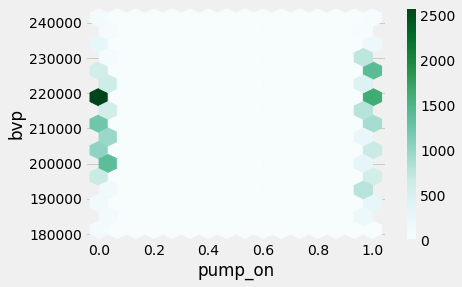

<Figure size 432x288 with 0 Axes>

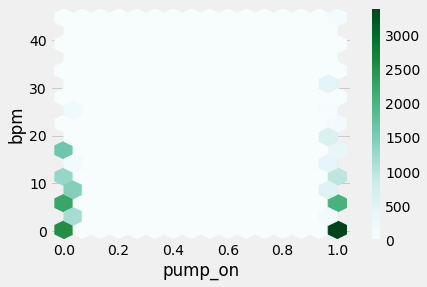

<Figure size 432x288 with 0 Axes>

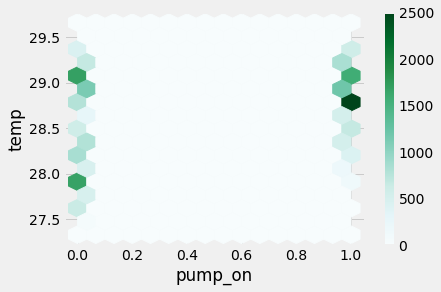

<Figure size 432x288 with 0 Axes>

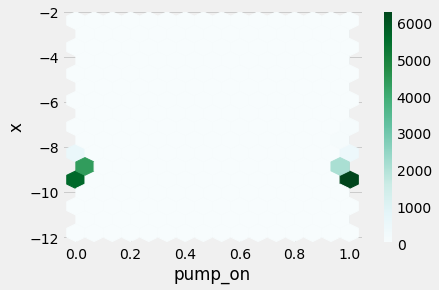

<Figure size 432x288 with 0 Axes>

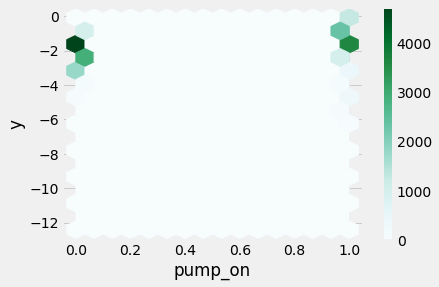

<Figure size 432x288 with 0 Axes>

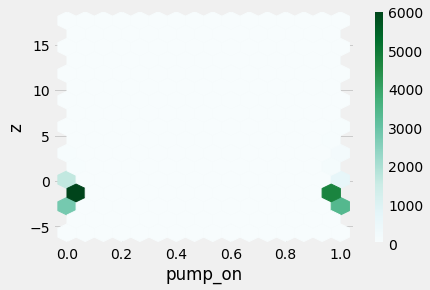

<Figure size 432x288 with 0 Axes>

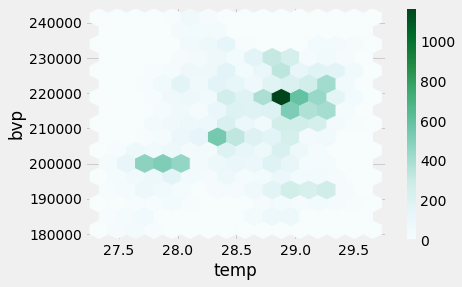

<Figure size 432x288 with 0 Axes>

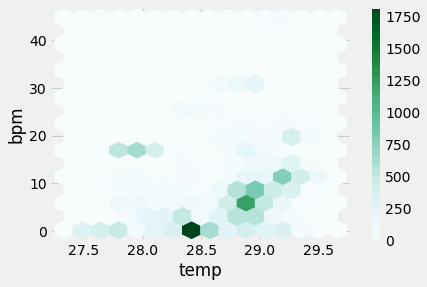

<Figure size 432x288 with 0 Axes>

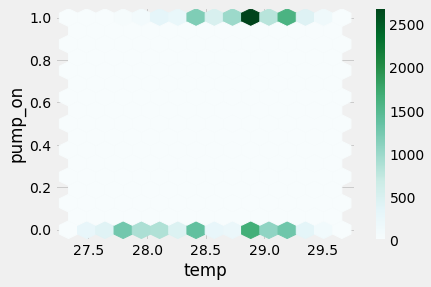

<Figure size 432x288 with 0 Axes>

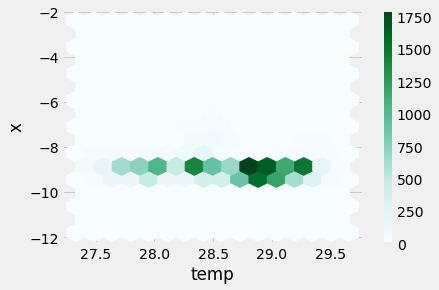

<Figure size 432x288 with 0 Axes>

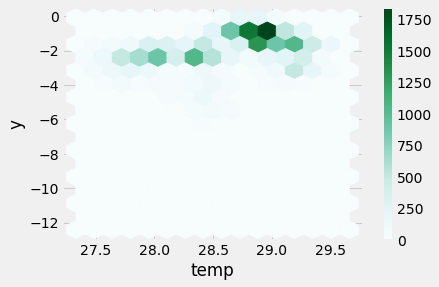

<Figure size 432x288 with 0 Axes>

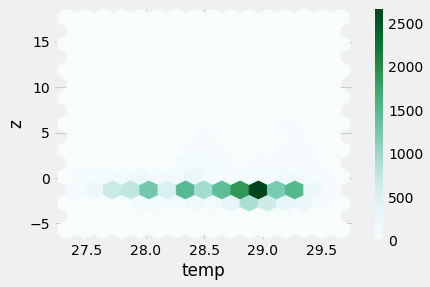

<Figure size 432x288 with 0 Axes>

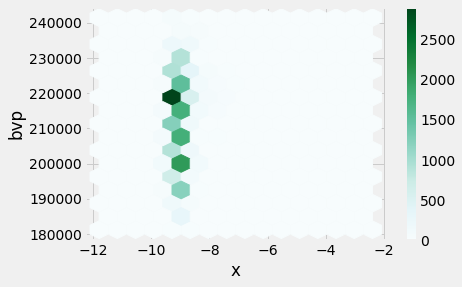

<Figure size 432x288 with 0 Axes>

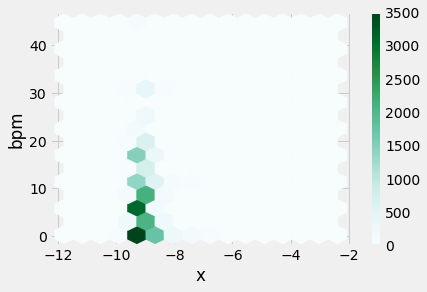

<Figure size 432x288 with 0 Axes>

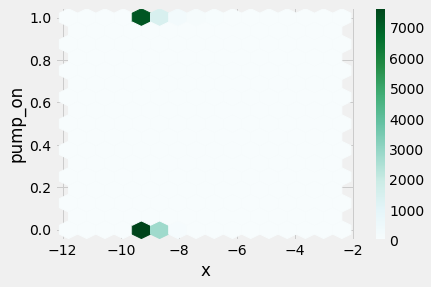

<Figure size 432x288 with 0 Axes>

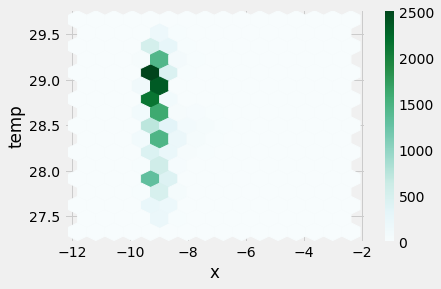

<Figure size 432x288 with 0 Axes>

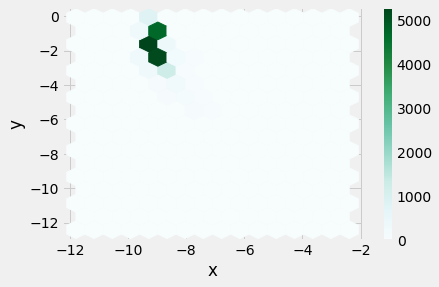

<Figure size 432x288 with 0 Axes>

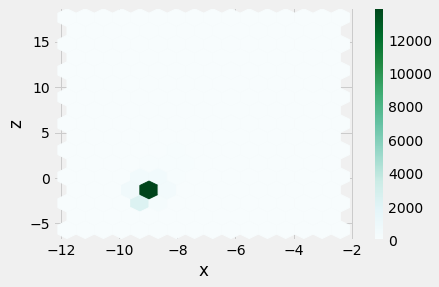

<Figure size 432x288 with 0 Axes>

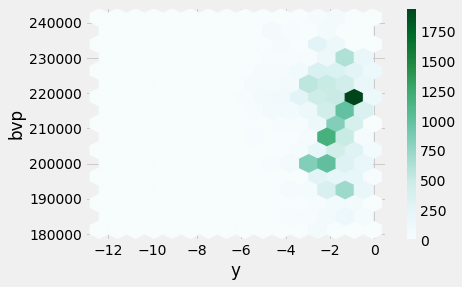

<Figure size 432x288 with 0 Axes>

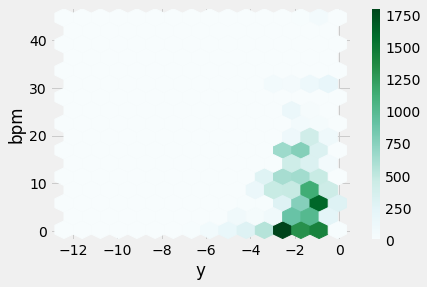

<Figure size 432x288 with 0 Axes>

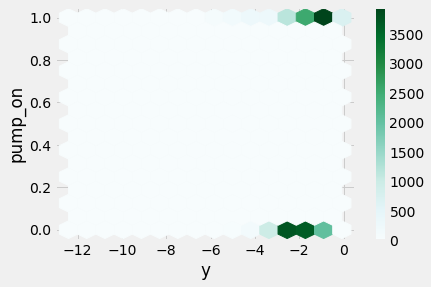

<Figure size 432x288 with 0 Axes>

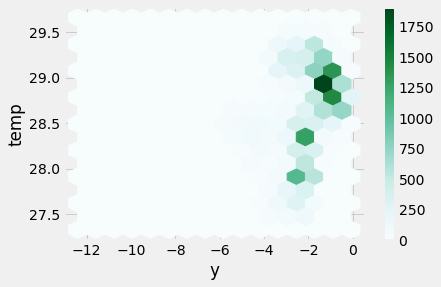

<Figure size 432x288 with 0 Axes>

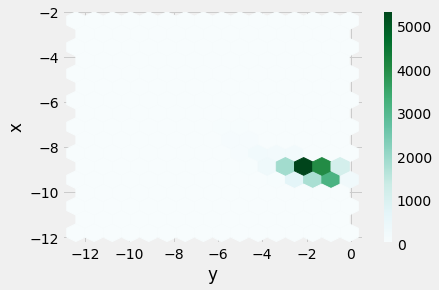

<Figure size 432x288 with 0 Axes>

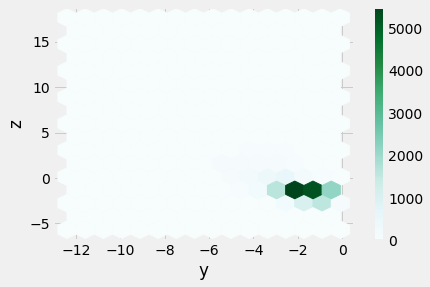

<Figure size 432x288 with 0 Axes>

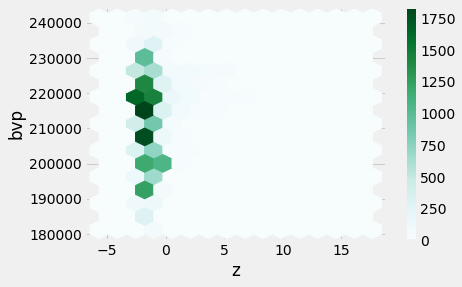

<Figure size 432x288 with 0 Axes>

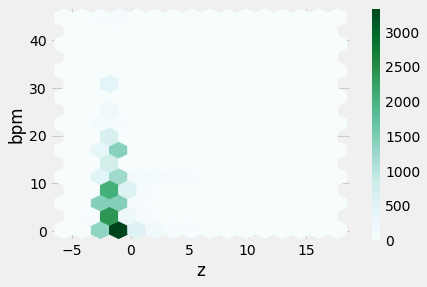

<Figure size 432x288 with 0 Axes>

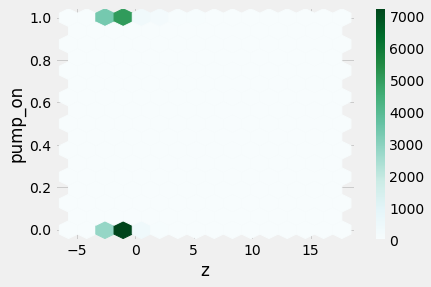

<Figure size 432x288 with 0 Axes>

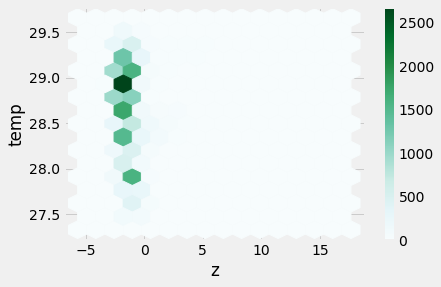

<Figure size 432x288 with 0 Axes>

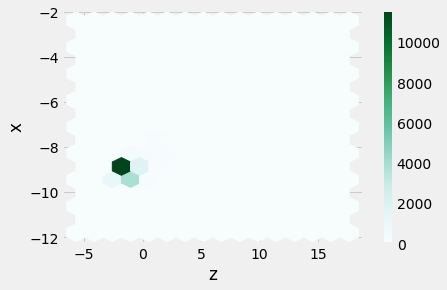

<Figure size 432x288 with 0 Axes>

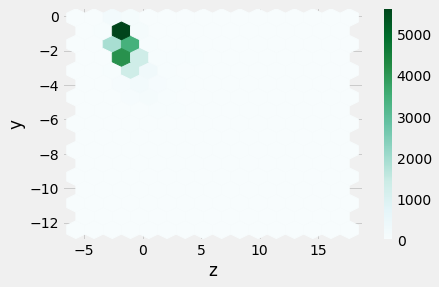

In [41]:
###########
## Plots ##
###########

"""
TO DO
- if it isn't a big overhead, remove the unnecessary graph pairs from the loop at the bottom, but it's not the end of the world to sort through at the end if you need to
- some down-sampling might have to occur so that the graphs are easier to interpret
- see if you can check if these images are already saved? so that you don't have to regenerate and save every time if you don't have to
- is there a way to make it so it saves but doesn't display? there's some stack error because there's too many graphs shown at once
"""

## Boxplots for each column
for column in continuous_cols:
    figure = plt.figure()
    boxplot = continuous_cols[[column]].boxplot()
    figure.savefig("plots/" + PARTICIPANT + "_boxplot_" + column + ".svg", format="svg")

## Histograms for each column
for column in continuous_cols:
    ## Calculate Freedman-Diaconis bin size
    q25 = continuous_cols[column].quantile(0.25)
    q75 = continuous_cols[column].quantile(0.75)
    max = continuous_cols[column].max()
    min = continuous_cols[column].min()
    num = len(continuous_cols)
    bin_width = (2*(q75 - q25)) /(num**(1/3))
    num_bins = math.ceil((max - min) / bin_width)

    ## Plot with the bin size determined above as num_bins
    figure = plt.figure()
    hist = continuous_cols[[column]].hist(bins=num_bins)
    figure.savefig("plots/" + PARTICIPANT + "_hist_" + column + ".svg", format="svg")

## Bar graphs for each column
for column in categorical_cols:
    figure = plt.figure()
    bar_graph = categorical_cols[[column]].value_counts().plot(kind="barh")
    figure.savefig("plots/" + PARTICIPANT + "_bar_" + column + ".svg", format="svg")

if 'vacuum_on' in data.columns:
    data = data.drop(columns = ['vacuum_on'])  # this one doesn't seem like it would influence? I guess I could keep it but it's not consistent across participants

for column in data:
    for column_2 in data:
        if column != column_2:
            ## need to do some downsampling or something here
            ## lots of unnecessary pairs but didn't seem work the time to get the distinct pairs
            figure1 = plt.figure()
            data.plot(x=column, y=column_2, kind = "scatter")
            figure.savefig("plots/bivariate/" + PARTICIPANT + "_" + column + "_" + column_2 + "_scatter.svg", format='svg')

            figure_2 = plt.figure()
            data.plot(x=column, y=column_2, kind = "hexbin", gridsize=15)
            figure_2.savefig("plots/" + PARTICIPANT + "_" + column + "_" + column_2 + "_hexbin.svg", format='svg')

In [3]:
#################
## Classifiers ##
#################

def xgboost(x_train, y_train, x_test, y_test, file_name):
    ## Create the model
    reg = xgb.XGBClassifier(n_estimators=1000)

    ## Fit the model
    reg.fit(x_train, y_train.values.ravel(),
            eval_set = [(x_train, y_train.values.ravel()), (x_test, y_test.values.ravel())],
            early_stopping_rounds = 50,
            verbose = False)

    ## Predict values from test features
    y_pred = reg.predict(x_test)

    ## Save the trained model for later
    reg.save_model(file_name)

    return y_pred


def logistic_regression(x_train, y_train, x_test, file_name):
    ## Create the model
    log_reg = LogisticRegression(solver='lbfgs', max_iter=1000)

    ## Fit the model
    log_reg.fit(x_train, y_train.values.ravel())

    ## Predict values from test features
    y_pred = log_reg.predict(x_test)

    ## Save the trained model for later
    with open(file_name, 'wb') as file:
        pickle.dump(log_reg, file)

    return y_pred


def support_vector(x_train, y_train, x_test, y_test, file_name):
    ## Create the model
    svclassifier = SVC(kernel='linear')

    ## Fit the model
    svclassifier.fit(x_train, y_train.values.ravel())

    ## Predict values from test features
    y_pred = svclassifier.predict(x_test)

    ## Save the trained model for later
    with open(file_name, 'wb') as file:
        pickle.dump(svclassifier, file)

    return y_pred


def feature_importance(trained_model, model_type):
    ## Access importance correctly depending on the model
    if model_type == "xgboost":
        importance = trained_model.feature_importances_
    elif model_type == "svm" or model_type == "log_reg":
        importance = trained_model.coef_[0]
    else:
        print("Invalid model type, please input another.")

    ## Iterate over and print the importance values
    for i, v in enumerate(importance):
        print("Feature: %0d, Score: %.5f" % (i,v))

    ## Plot the importance values for each feature
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()

    ## Save the figure once you make sure this works

    return

In [4]:
#############
## Metrics ##
#############

def general_metrics(true_labels, predicted_labels, file_name):
    tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels, labels=[0.0, 1.0]).ravel()
    print("True Negative: {}".format(tn))
    print("False Positive: {}".format(fp))
    print("False Negative: {}".format(fn))
    print("True Positive: {}".format(tp))

    mse = mean_squared_error(y_true=true_labels,
                             y_pred=predicted_labels)
    print('\nMeans Squared Error: {}'.format(mse))

    mae = mean_absolute_error(y_true=true_labels,
                              y_pred=predicted_labels)
    print('\nMean Absolute Error: {}'.format(mae))

    f1 = f1_score(true_labels, predicted_labels, average=None)
    print('\nF1 Score: {}'.format(f1))

    precision = tp / (tp + fp)
    print("\nPrecision: {}".format(precision))

    recall = tp / (tp + fn)
    print("\nRecall: {} ".format(recall))

    accuracy = (tp + tn) / (tp + fp + tn + fn)
    print("\nAccuracy: {}\n ".format(accuracy))

    ## Write to file in the same order as the spread sheet so I can copy and paste easily
    with open(file_name, 'w') as f:
        f.write(str(mse) + "\n")
        f.write(str(mae) + "\n")
        f.write(str(fp) + "\n")
        f.write(str(tp) + "\n")
        f.write(str(fn) + "\n")
        f.write(str(tn) + "\n")
        f.write("{}".format(f1))
        f.write("\n" + str(precision) + "\n")
        f.write(str(recall) + "\n")
        f.write(str(accuracy) + "\n")

    return

In [5]:
#######################
## Train Test Splits ##
#######################
def data_windowing(window_size, increment):
    temp_y = data[['pump_on']]
    temp_y = temp_y.replace({0.0: int(0), 1.0: int(1), 'off': int(0), 'on': int(1)})
    temp_x = data[["bvp", "bpm", "temp", "x", "y", "z"]]

    if len(temp_y) != len(temp_x):
        print("Improper split - may cause inconsistencies, please check data")
        return

    features = []
    labels = []
    i = 0

    while (i + window_size + 1) < len(data):
        size = i + window_size
        x = temp_x.iloc[i:size]
        y = temp_y.iloc[size+1]

        x = np.array(x)
        x = x.flatten()
        y = np.array(y)
        y = y.flatten()

        features.append(x)
        labels.append(y)

        i += increment

    features = pd.DataFrame(features)
    features.fillna(0)
    labels = pd.DataFrame(labels)

    return features, labels

def condition_A(data, size):
    ## Relabel and split into train and test
    y = data[['pump_on']]
    y = y.replace({0.0: int(0), 1.0: int(1), 'off': int(0), 'on': int(1)})
    x = data[["bvp", "bpm", "temp", "x", "y", "z"]]

    ## Get train and test
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = size, shuffle = False)

    ## Normalize bvp
    x_train.bvp = (x_train.bvp - x_train.bvp.mean()) / (x_train.bvp.max() - x_train.bvp.min())
    x_test.bvp = (x_test.bvp - x_test.bvp.mean()) / (x_test.bvp.max() - x_test.bvp.min())

    return x_train, x_test, y_train, y_test

def condition_B(data, size):
    x, y = data_windowing(45, 22)

    ## Get train and test
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = size, shuffle = False)

    ## Normalize bvp
    #x_train.bvp = (x_train.bvp - x_train.bvp.mean()) / (x_train.bvp.max() - x_train.bvp.min())
    #x_test.bvp = (x_test.bvp - x_test.bvp.mean()) / (x_test.bvp.max() - x_test.bvp.min())

    return x_train, x_test, y_train, y_test

    return

def condition_C(data, size):
    ## Relabel and split into train and test
    y = data[['pump_on']]
    y = y.replace({0.0: int(0), 1.0: int(1), 'off': int(0), 'on': int(1)}) ## doesn't look like it's working
    x = data[["bvp", "bpm", "temp", "x", "y", "z"]]

    ## Get the indices for the window splices
    total_length = len(data)
    test_length = int(0.2*total_length)
    test_start_index = total_length - test_length
    train_length  = int(size*total_length)
    train_end_index = test_start_index
    train_start_index = test_start_index - train_length

    ## Break up train and test according to these indices
    x_train = x[train_start_index:train_end_index]
    x_test = x[test_start_index:]
    y_train = y[train_start_index:train_end_index]
    y_test = y[test_start_index:]

    ## Normalize bvp
    x_train.bvp = (x_train.bvp - x_train.bvp.mean()) / (x_train.bvp.max() - x_train.bvp.min())
    x_test.bvp = (x_test.bvp - x_test.bvp.mean()) / (x_test.bvp.max() - x_test.bvp.min())

    return x_train, x_test, y_train, y_test

def condition_D(data, size):
    x, y = data_windowing(45, 22)

    ## Get the indices for the window splices
    total_length = len(x)
    test_length = int(0.2*total_length)
    test_start_index = total_length - test_length
    train_length  = int(size*total_length)
    train_end_index = test_start_index
    train_start_index = test_start_index - train_length

    ## Break up train and test according to these indices
    x_train = x[train_start_index:train_end_index]
    x_test = x[test_start_index:]
    y_train = y[train_start_index:train_end_index]
    y_test = y[test_start_index:]

    ## Normalize bvp
    #x_train.bvp = (x_train.bvp - x_train.bvp.mean()) / (x_train.bvp.max() - x_train.bvp.min())
    #x_test.bvp = (x_test.bvp - x_test.bvp.mean()) / (x_test.bvp.max() - x_test.bvp.min())

    return x_train, x_test, y_train, y_test



In [6]:
###################
## Execute Tests ##
###################

def run_tests(condition):
    ## For every split in the listed train test splits, train different models
    if condition == 'A':
        function = condition_A
    elif condition == 'B':
        function = condition_B
    elif condition == 'C':
        function = condition_C
    elif condition == 'D':
        function = condition_D
    else:
        print("Invalid Training Condition: please pick another")
        return

    if (condition == 'A') or (condition == 'B'):
        for size in TEST_SIZES:
            print("Training with test set size: {}".format(size))

            ## Get correct train test splits
            x_train, x_test, y_train, y_test = function(data, size)

            ## XGBoost with this train/test split
            #file_name_1 = "models/xgboost/" + PARTICIPANT + "_" + condition + "_test_size_" + str(size)
            #metrics_file_name_1 = "metrics/" + PARTICIPANT + "_" + condition + "_xgboost_test_size_" + str(size)
            #print("\n\nXGBoost\n")
            #predictions_1 = xgboost(x_train, y_train, x_test, y_test, file_name_1)
            #general_metrics(y_test, predictions_1, metrics_file_name_1)

            ## Logistic Regression with this train/test split
            #file_name_2= "models/logistic_regression/" + PARTICIPANT + "_" + condition + "_test_size_" + str(size)
            #metrics_file_name_2 = "metrics/" + PARTICIPANT + "_" + condition + "_log_reg_test_size_" + str(size)
            #print("\n\nLogistic Regression\n")
            #predictions_2 = logistic_regression(x_train, y_train, x_test, file_name_2)
            #general_metrics(y_test, predictions_2, metrics_file_name_2)

            ## SVM with this train/test split
            file_name_3= "models/svm/" + PARTICIPANT + "_" + condition + "_test_size_" + str(size)
            metrics_file_name_3 = "metrics/" + PARTICIPANT + "_" + condition + "_svm_test_size_" + str(size)
            print("\n\nSVM\n")
            predictions_3 = support_vector(x_train, y_train, x_test, y_test, file_name_3)
            general_metrics(y_test, predictions_3, metrics_file_name_3)

    else:
        for size in TRAIN_SIZES:
            print("Training with train set size: {}".format(size))

            ## Get correct train test splits
            x_train, x_test, y_train, y_test = function(data, size)

            ## XGBoost with this train/test split
            #file_name_1 = "models/xgboost/" + PARTICIPANT + "_" + condition + "_train_size_" + str(size)
            #metrics_file_name_1 = "metrics/" + PARTICIPANT + "_" + condition + "_xgboost_train_size_" + str(size)
            #print("\n\nXGBoost\n")
            #predictions_1 = xgboost(x_train, y_train, x_test, y_test, file_name_1)
            #general_metrics(y_test, predictions_1, metrics_file_name_1)

            ## SVM with this train/test split
            file_name_3= "models/svm/" + PARTICIPANT + "_" + condition + "_train_size_" + str(size)
            metrics_file_name_3 = "metrics/" + PARTICIPANT + "_" + condition + "_svm_train_size_" + str(size)
            print("\n\nSVM\n")
            predictions_3 = support_vector(x_train, y_train, x_test, y_test, file_name_3)
            general_metrics(y_test, predictions_3, metrics_file_name_3)

            ## Logistic Regression with this train/test split
            #file_name_2= "models/logistic_regression/" + PARTICIPANT + "_" + condition + "_train_size_" + str(size)
            #metrics_file_name_2 = "metrics/" + PARTICIPANT + "_" + condition + "_log_reg_train_size_" + str(size)
            #print("\n\nLogistic Regression\n")
            #predictions_2 = logistic_regression(x_train, y_train, x_test, file_name_2)
            #general_metrics(y_test, predictions_2, metrics_file_name_2)



    return

In [ ]:
###############
## Run Tests ##
###############

print("CONDITION A \n")
run_tests('A')
print("CONDITION B \n")
run_tests('B')
print("CONDITION C \n")
run_tests('C')
print("CONDITION D \n")
run_tests('D')

CONDITION A 

Training with test set size: 0.4


SVM



In [ ]:
########################
## Feature Importance ##
########################
loaded_model1 = pickle.load(open("models/svm/participant_8_test_size_0.3", 'rb'))
feature_importance(loaded_model1, 'svm')

loaded_model2 = pickle.load(open("models/logistic_regression/participant_8_test_size_0.3", 'rb'))
feature_importance(loaded_model2, 'log_reg')

loaded_model3 = xgb.XGBClassifier(n_estimators=1000)
loaded_model3.load_model("models/xgboost/participant_8_test_size_0.3")
feature_importance(loaded_model3, 'xgboost')

## Feature importance when I look at the time series??

In [ ]:
##################################
## Cross Participant Validation ##
##################################